In [1]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt

In [108]:
#This data has not had hit merging applied! So we will likely be seeing worse results in this first run through 
data = np.load('hitwise_detector_sim_0002459.npz')
neutrino_vertices = data['first']
hit_array = data['second']
np.shape(neutrino_vertices)
#np.shape(hit_array)

(5978, 5)

In [3]:
#Let's write a quick function to sort the numpy array by hit time.
#np.argsort returns a list of row indexes that would sort time in ascending order
#Then, the array[np.argsort()] uses 'fancy indexing' to sort the array rows by the provided list of indexes. Useful functionality!
def SortByTime(array):
    sorted_array = array[np.argsort(array[:,5])]
    return(sorted_array)

def SortByNN(array):
    sorted_array = array[np.argsort(array[:,0])]
    return(sorted_array)

In [4]:
sorted_hits = SortByTime(hit_array)

In [120]:
#A useful data structure that can serve as a test of energy efficiency
neutrino_total_PE_array = np.zeros((5979, 2))
for i in range(5979):
    PEs = 0.
    sub_array = sorted_hits[sorted_hits[:, 0] == i]
    if np.shape(sub_array)[0] > 0:
        for hit in sub_array:
            PEs += hit[6]
    neutrino_total_PE_array[i][0] = i
    neutrino_total_PE_array[i][1] = PEs

print(neutrino_total_PE_array)

[[0.00000000e+00 7.34770243e+01]
 [1.00000000e+00 0.00000000e+00]
 [2.00000000e+00 1.28117544e+03]
 ...
 [5.97600000e+03 0.00000000e+00]
 [5.97700000e+03 3.66649168e+03]
 [5.97800000e+03 0.00000000e+00]]


In [167]:
#This the dumbest algorithm one could imagine - simply splitting when there is a > 3 ns difference between hits
np.shape(sorted_hits)
times = sorted_hits[: , 5]
nns = sorted_hits[: ,0]
dt = np.diff(times)
split_indices = np.where(dt > 3)[0] + 1
groups = np.split(sorted_hits, split_indices)
#for i, group in enumerate(groups): 
#    if 1 == 1: #len(np.unique(group[:,0])) > 1:
#        print(i)
#        print((group[:,0]))
#print(groups[23][:, 0]) #this line prints the neutrino numbers of all the hits in the 5th group. 

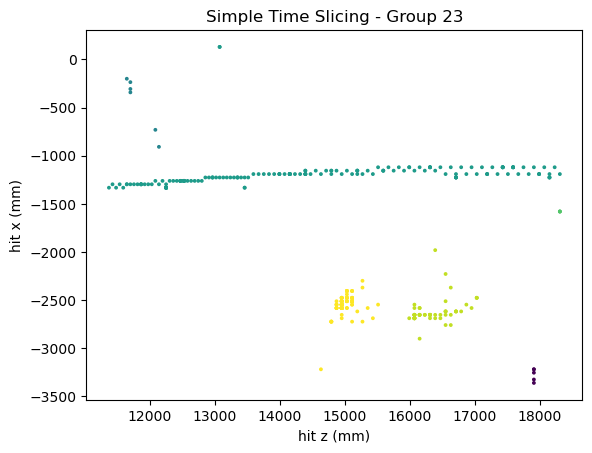

In [168]:
group_number = 23 #204
hit_xs = groups[group_number][:, 2]
hit_zs = groups[group_number][:, 4]
hit_nns = groups[group_number][:, 0]
plt.scatter(hit_zs, hit_xs, c = hit_nns, s = 3)
plt.xlabel("hit z (mm)")
plt.ylabel("hit x (mm)")
plt.title(f"Simple Time Slicing - Group {group_number}")
plt.show()

In [169]:
#Simple algorithm to determine the energy efficiency of a grouping
group_no = 23
events_represented = np.unique(groups[group_number][:, 0])
for neutrino_number in events_represented:
    total_PE_share = 0.
    for hit in groups[group_no][:, :]:
        if hit[0] == neutrino_number:
            total_PE_share += hit[6]
            
    total_event_PE = neutrino_total_PE_array[int(neutrino_number)][1]
    percent_PE_here = (total_PE_share / total_event_PE) * 100
    print(f"For neutrino number {neutrino_number}, group {group_no} contains {percent_PE_here}% of event PE")

For neutrino number 28.0, group 23 contains 61.18249629959314% of event PE
For neutrino number 33.0, group 23 contains 12.580029803328552% of event PE
For neutrino number 34.0, group 23 contains 99.28454935214678% of event PE
For neutrino number 36.0, group 23 contains 100.0% of event PE
For neutrino number 38.0, group 23 contains 90.69517393750779% of event PE
For neutrino number 39.0, group 23 contains 98.91451473604351% of event PE


In [28]:
min_window_length = 10 #ns
max_window_length = 19 #ns this seems awfully quick..
threshold1 = 60 #MeV, need to have it in PE, first threshold is 500 MeV?? Seems unrealistically high, won't get tripped 
threshold2 = 50 #MeV, 
starting_time = sorted_hits[0][5]
#print(starting_time)
starting_energy = sorted_hits[0][6]
#print(starting_energy)

#Let's just calculate the total energy in the minimum initial window. 
hits_in_min_window = []
energy_in_min_window = 0.
running_window = sorted_hits

#this creates a minimum window
indexes = []
for i, hit in enumerate(sorted_hits):
    if hit[5] < (starting_time + min_window_length):
        running_window = sorted_hits[0:i, :]
        #print(running_window)
        print(hit[5])
        energy_in_min_window += hit[6]
        indexes.append(i)
    if hit[5] > (starting_time + min_window_length):
        break
#grab min and max indexes
#print(running_window)
#print(np.sum(running_window[ :,6]))

#this slides over our hits in incriments of 1 index, to find total time slice we just take the index of max(indexes)+i of when it terminates. or +1 something like that

max_index = []
window_energies = []
max_times = []
for i in range(500):
    running_window = sorted_hits[ (min(indexes)+i) : (max(indexes)+i), : ] #this is the sort of object I want to slide around...
    window_energy = np.sum(running_window[ :, 6])
    indexes_covered = (min(indexes)+i, max(indexes)+i)
    times_covered = (sorted_hits[min(indexes)+i][5], sorted_hits[max(indexes)+i][5])
    
    #print(f'{indexes_covered} - {times_covered}, {window_energy}')
    max_index.append(max(indexes)+i)
    window_energies.append(window_energy)

    max_times.append(sorted_hits[max(indexes)+i][5])
    print(f"{sorted_hits[max(indexes)+i][5]}, {sorted_hits[max(indexes)+i][0]}")
#perhaps a running plot of the window energies will be elucidating:



50.88723472018113
50.91616205002854
50.93293631044124
50.95206311624096
50.98795139310459


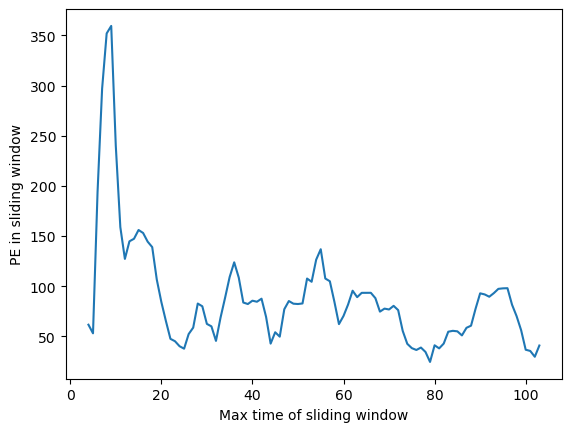

In [20]:
plt.plot(max_index, window_energies)
plt.xlabel("Max time of sliding window")
plt.ylabel("PE in sliding window")
plt.show()

In [6]:
sorted_nn = SortByNN(hit_array)
event_slices = []

for i in range(500):
    neutrino_number = i
    hits_in_event = []
    for hit in sorted_nn:
        if hit[0] == neutrino_number:
            hits_in_event.append(hit[6])
            
    if len(hits_in_event) > 1 : 
        event_slices.append(hits_in_event)

Text(0.5, 0, 'Average Hit Energy (PEs)')

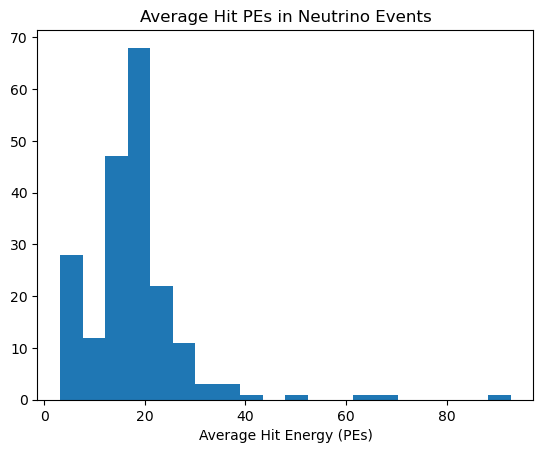

In [7]:
mean_energies = []
min_energies = []
max_energies = []
n_hits = []
for i, event in enumerate(event_slices):
    #print(event)
    n_hits.append(len(event))
    min_energies.append(min(event))
    max_energies.append(max(event))
    mean_energies.append(np.average(event))

plt.hist(mean_energies, bins = 20)
plt.title("Average Hit PEs in Neutrino Events")
plt.xlabel("Average Hit Energy (PEs)")

Text(0.5, 0, 'Max PE hit')

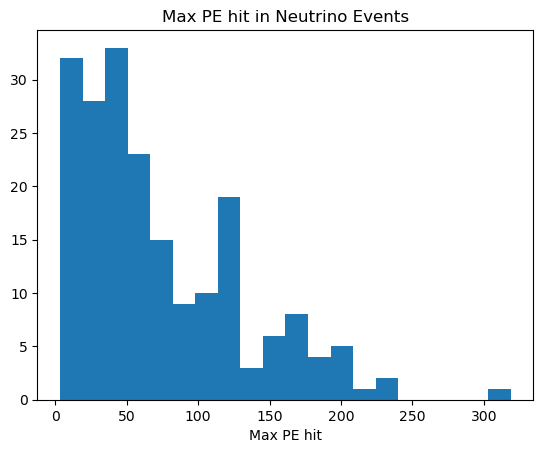

In [8]:
plt.hist(max_energies, bins =20)
plt.title("Max PE hit in Neutrino Events")
plt.xlabel("Max PE hit")

Text(0.5, 0, 'Min PE hit')

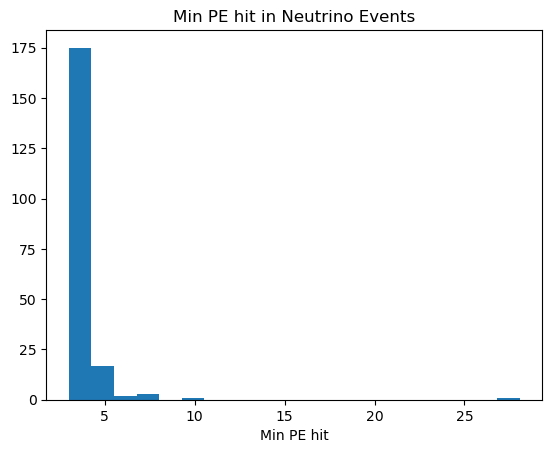

In [9]:
plt.hist(min_energies, bins = 20)
plt.title("Min PE hit in Neutrino Events")
plt.xlabel("Min PE hit") #less than 3 MeV subtracted!

Text(0.5, 0, 'number of hits')

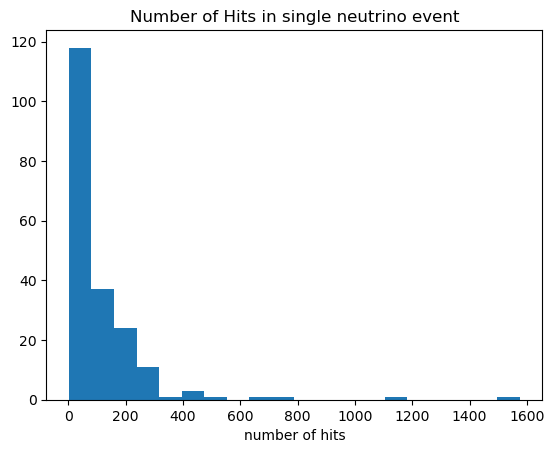

In [10]:
plt.hist(n_hits, bins = 20)
plt.title("Number of Hits in single neutrino event")
plt.xlabel("number of hits") #less than 3 MeV subtracted!

In [11]:
#this cell groups hits by neutrino number (so interaction) to allow us to pull event by event statistics. Only save if > 1 hit in TMS
grouped_hits = []
sorted_nn = SortByNN(hit_array)
for i in range(500):
    neutrino_number = i
    hits_in_event = []
    for hit in sorted_nn:
        if hit[0] == neutrino_number:
            hits_in_event.append(hit)
            
    if len(hits_in_event) > 15 : 
        grouped_hits.append(hits_in_event)


        

In [17]:
time_ranges = []
time_stdevs = []
for event in grouped_hits:
    times = []
    for hit in event:
        times.append(hit[5])
    time_range = max(times) - min(times)
    time_ranges.append(time_range)
    time_stdevs.append((np.std(times)))
#print(time_stdevs)

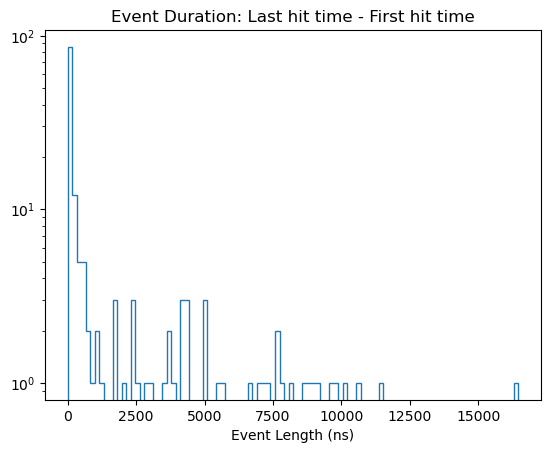

1718.537210696725


In [56]:
plt.hist(time_ranges, bins = 100, histtype = 'step')
plt.yscale('log')
plt.xlabel('Event Length (ns)')
#plt.xlim(0,1000)
plt.title('Event Duration: Last hit time - First hit time')
plt.show()
print(np.average(time_ranges))

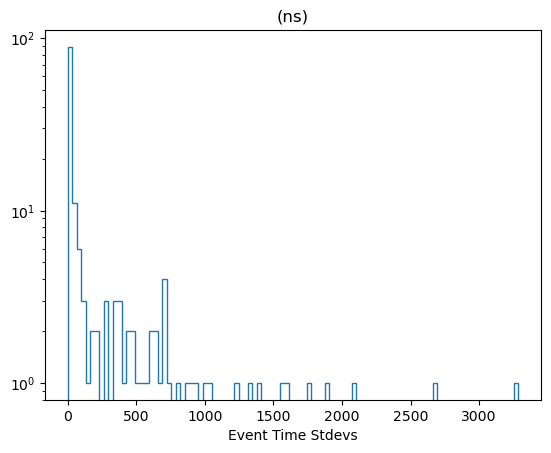

In [16]:
plt.hist(time_stdevs, bins = 100, histtype = 'step')
plt.yscale('log')
plt.xlabel('Event Time Stdevs')
#plt.xlim(0,1000)
plt.title('(ns)')
plt.show()
